Low-Dose CT (ADMM w/ Total Variation)
=====================================

This example demonstrates the use of class
[admm.ADMM](../_autosummary/scico.admm.rst#scico.admm.ADMM) to solve a
low-dose CT reconstruction problem with anisotropic total variation
(TV) regularization.

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where $A$ is the Radon transform, $\mathbf{y}$ is the sinogram, $C$ is
a 2D Finite Difference operator, and $\mathbf{x}$ is the desired
image.

The weighted norm is an approximation to the Poisson negative log
likelihood <cite data-cite="sauer-1993-local"/>.

In [1]:
import numpy as np

import jax

from xdesign import Soil, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.admm import ADMM, LinearSubproblemSolver
from scico.linop.radon_astra import ParallelBeamProjector
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size

np.random.seed(0)
x_gt = discrete_phantom(Soil(porosity=0.80), size=384)
x_gt = np.ascontiguousarray(np.pad(x_gt, (64, 64)))
x_gt = np.clip(x_gt, 0, np.inf)  # clip to positive values
x_gt = jax.device_put(x_gt)  # convert to jax type, push to GPU

Configure CT projection operator and generate synthetic measurements.

In [3]:
n_projection = 360  # number of projections
Io = 1e3  # source flux
𝛼 = 1e-2  # attenuation coefficient

angles = np.linspace(0, 2 * np.pi, n_projection)  # evenly spaced projection angles
A = ParallelBeamProjector(x_gt.shape, 1.0, N, angles)  # Radon transform operator
y_c = A @ x_gt  # sinogram

Add Poisson noise to projections according to

$$\mathrm{counts} \sim \mathrm{Poi}\left(I_0 exp\left\{- \alpha A
\mathbf{x} \right\}\right)$$

$$\mathbf{y} = - \frac{1}{\alpha} \log\left(\mathrm{counts} /
I_0\right).$$

We use the NumPy random functionality so we can generate using 64-bit
numbers.

In [4]:
counts = np.random.poisson(Io * snp.exp(-𝛼 * A @ x_gt))
counts = np.clip(counts, a_min=1, a_max=np.inf)  # replace any 0s count with 1
y = -1 / 𝛼 * np.log(counts / Io)
y = jax.device_put(y)  # convert back to float32

Setup post processing.  For this example, we clip all reconstructions
to the range of the ground truth.

In [5]:
def postprocess(x):
    return snp.clip(x, 0, snp.max(x_gt))

Compute an FBP reconstruction as an initial guess.

In [6]:
x0 = postprocess(A.fbp(y))

Set up and solve the un-weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_1.$$

In [7]:
# Note that rho and lambda were selected via a parameter sweep (not
# shown here).
ρ = 2.5e3  # ADMM penalty parameter
lambda_unweighted = 2.56e2  # regularization strength

maxiter = 50  # number of ADMM iterations
max_inner_iter = 10  # number of CG iterations per ADMM iteration

f = loss.SquaredL2Loss(y=y, A=A)

admm_unweighted = ADMM(
    f=f,
    g_list=[lambda_unweighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[ρ],
    x0=x0,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
print(f"Solving on {device_info()}\n")
admm_unweighted.solve()
x_unweighted = postprocess(admm_unweighted.x)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.52e+00  2.444e+07    6.286e+01  1.298e+02


   1  3.73e+00  1.860e+07    1.854e+01  1.149e+02


   2  3.96e+00  1.370e+07    2.038e+01  9.751e+01
   3  4.16e+00  1.030e+07    1.965e+01  8.038e+01


   4  4.34e+00  8.001e+06    1.717e+01  6.543e+01


   5  4.55e+00  6.535e+06    1.509e+01  5.167e+01


   6  4.85e+00  5.711e+06    1.340e+01  3.821e+01


   7  5.10e+00  5.340e+06    1.154e+01  2.529e+01


   8  5.33e+00  5.221e+06    9.024e+00  1.477e+01


   9  5.58e+00  5.191e+06    6.051e+00  8.554e+00


  10  5.81e+00  5.197e+06    4.064e+00  5.073e+00


  11  6.03e+00  5.214e+06    2.882e+00  3.460e+00


  12  6.24e+00  5.229e+06    2.154e+00  2.809e+00


  13  6.44e+00  5.241e+06    1.748e+00  2.451e+00


  14  6.67e+00  5.250e+06    1.487e+00  2.178e+00


  15  6.87e+00  5.256e+06    1.298e+00  1.944e+00


  16  7.08e+00  5.261e+06    1.150e+00  1.739e+00


  17  7.29e+00  5.264e+06    1.035e+00  1.557e+00


  18  7.50e+00  5.266e+06    9.446e-01  1.395e+00


  19  7.71e+00  5.268e+06    8.657e-01  1.258e+00


  20  7.93e+00  5.270e+06    7.970e-01  1.143e+00


  21  8.19e+00  5.271e+06    7.375e-01  1.045e+00


  22  8.40e+00  5.272e+06    6.855e-01  9.626e-01


  23  8.63e+00  5.273e+06    6.406e-01  8.925e-01


  24  8.84e+00  5.274e+06    6.006e-01  8.295e-01
  25  9.03e+00  5.275e+06    5.713e-01  7.726e-01


  26  9.22e+00  5.276e+06    5.379e-01  7.292e-01
  27  9.41e+00  5.277e+06    5.081e-01  6.795e-01


  28  9.60e+00  5.278e+06    4.855e-01  6.317e-01
  29  9.78e+00  5.278e+06    4.616e-01  5.921e-01


  30  9.95e+00  5.279e+06    4.430e-01  5.530e-01
  31  1.01e+01  5.280e+06    4.244e-01  5.203e-01


  32  1.03e+01  5.281e+06    4.067e-01  4.917e-01
  33  1.05e+01  5.281e+06    3.899e-01  4.663e-01


  34  1.06e+01  5.282e+06    3.739e-01  4.431e-01
  35  1.08e+01  5.282e+06    3.619e-01  4.236e-01


  36  1.10e+01  5.283e+06    3.485e-01  4.085e-01
  37  1.11e+01  5.283e+06    3.359e-01  3.888e-01


  38  1.12e+01  5.284e+06    3.245e-01  3.687e-01
  39  1.14e+01  5.284e+06    3.136e-01  3.507e-01


  40  1.15e+01  5.285e+06    3.031e-01  3.350e-01
  41  1.17e+01  5.285e+06    2.934e-01  3.198e-01


  42  1.19e+01  5.285e+06    2.845e-01  3.049e-01
  43  1.20e+01  5.286e+06    2.762e-01  2.919e-01


  44  1.21e+01  5.286e+06    2.682e-01  2.798e-01
  45  1.23e+01  5.286e+06    2.618e-01  2.697e-01


  46  1.24e+01  5.287e+06    2.541e-01  2.561e-01
  47  1.25e+01  5.287e+06    2.478e-01  2.473e-01


  48  1.27e+01  5.287e+06    2.415e-01  2.391e-01
  49  1.28e+01  5.287e+06    2.352e-01  2.305e-01


Set up and solve the weighted reconstruction problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_W^2 + \lambda \| C \mathbf{x} \|_1 \;,$$

where

  $$W = \mathrm{diag}\left\{\exp( \sqrt{\mathbf{y}}) \right\}.$$

In [8]:
lambda_weighted = 1.14e2

weights = counts / Io  # scaled by Io to balance the data vs regularization term
f = loss.WeightedSquaredL2Loss(y=y, A=A, W=linop.Diagonal(weights))

admm_weighted = ADMM(
    f=f,
    g_list=[lambda_weighted * functional.L1Norm()],
    C_list=[linop.FiniteDifference(x_gt.shape)],
    rho_list=[ρ],
    maxiter=maxiter,
    x0=x0,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": max_inner_iter}),
    verbose=True,
)
admm_weighted.solve()
x_weighted = postprocess(admm_weighted.x)

/nh/u/mccann/Project/scico/scico/linop/_linop.py:159: UserWarning: Argument 1 of 1 is an np.ndarray. Will cast it to DeviceArray. To suppress this warning cast all np.ndarrays to DeviceArray first.
  self.diagonal = util.ensure_on_device(diagonal)


Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  4.67e-01  1.290e+07    2.941e+01  6.002e+01


   1  6.86e-01  1.140e+07    6.317e+00  5.815e+01


   2  8.93e-01  9.833e+06    6.138e+00  5.561e+01
   3  1.09e+00  8.405e+06    6.494e+00  5.265e+01


   4  1.28e+00  7.129e+06    6.652e+00  4.946e+01


   5  1.51e+00  6.012e+06    6.794e+00  4.604e+01


   6  1.76e+00  5.050e+06    6.697e+00  4.260e+01


   7  2.00e+00  4.229e+06    6.414e+00  3.923e+01


   8  2.20e+00  3.535e+06    6.111e+00  3.599e+01


   9  2.41e+00  2.954e+06    5.749e+00  3.289e+01


  10  2.62e+00  2.473e+06    5.471e+00  2.982e+01
  11  2.80e+00  2.085e+06    5.239e+00  2.679e+01


  12  3.01e+00  1.779e+06    5.025e+00  2.366e+01


  13  3.23e+00  1.551e+06    4.865e+00  2.038e+01


  14  3.45e+00  1.393e+06    4.617e+00  1.702e+01


  15  3.69e+00  1.291e+06    4.265e+00  1.362e+01


  16  3.92e+00  1.234e+06    3.780e+00  1.033e+01


  17  4.12e+00  1.206e+06    3.143e+00  7.545e+00


  18  4.33e+00  1.195e+06    2.517e+00  5.343e+00


  19  4.54e+00  1.192e+06    1.936e+00  3.813e+00


  20  4.77e+00  1.192e+06    1.488e+00  2.732e+00


  21  5.00e+00  1.193e+06    1.190e+00  1.924e+00


  22  5.23e+00  1.195e+06    9.710e-01  1.348e+00


  23  5.46e+00  1.196e+06    7.596e-01  1.109e+00


  24  5.69e+00  1.197e+06    6.369e-01  1.001e+00


  25  5.93e+00  1.198e+06    5.655e-01  9.023e-01


  26  6.19e+00  1.198e+06    5.092e-01  8.254e-01


  27  6.44e+00  1.199e+06    4.593e-01  7.677e-01


  28  6.66e+00  1.199e+06    4.199e-01  7.154e-01


  29  6.91e+00  1.199e+06    3.887e-01  6.671e-01


  30  7.13e+00  1.199e+06    3.621e-01  6.242e-01


  31  7.36e+00  1.200e+06    3.373e-01  5.896e-01
  32  7.55e+00  1.200e+06    3.154e-01  5.595e-01


  33  7.76e+00  1.200e+06    2.967e-01  5.316e-01


  34  7.98e+00  1.200e+06    2.795e-01  5.075e-01
  35  8.19e+00  1.200e+06    2.644e-01  4.848e-01


  36  8.40e+00  1.200e+06    2.514e-01  4.625e-01
  37  8.58e+00  1.200e+06    2.399e-01  4.411e-01


  38  8.78e+00  1.200e+06    2.292e-01  4.226e-01


  39  9.00e+00  1.200e+06    2.194e-01  4.053e-01


  40  9.22e+00  1.200e+06    2.102e-01  3.900e-01


  41  9.44e+00  1.200e+06    2.015e-01  3.766e-01
  42  9.64e+00  1.200e+06    1.936e-01  3.639e-01


  43  9.83e+00  1.201e+06    1.862e-01  3.518e-01


  44  1.00e+01  1.201e+06    1.791e-01  3.407e-01


  45  1.11e+01  1.201e+06    1.725e-01  3.305e-01


  46  1.13e+01  1.201e+06    1.663e-01  3.216e-01


  47  1.15e+01  1.201e+06    1.601e-01  3.127e-01
  48  1.17e+01  1.201e+06    1.549e-01  3.044e-01


  49  1.19e+01  1.201e+06    1.494e-01  2.959e-01


Show recovered images.

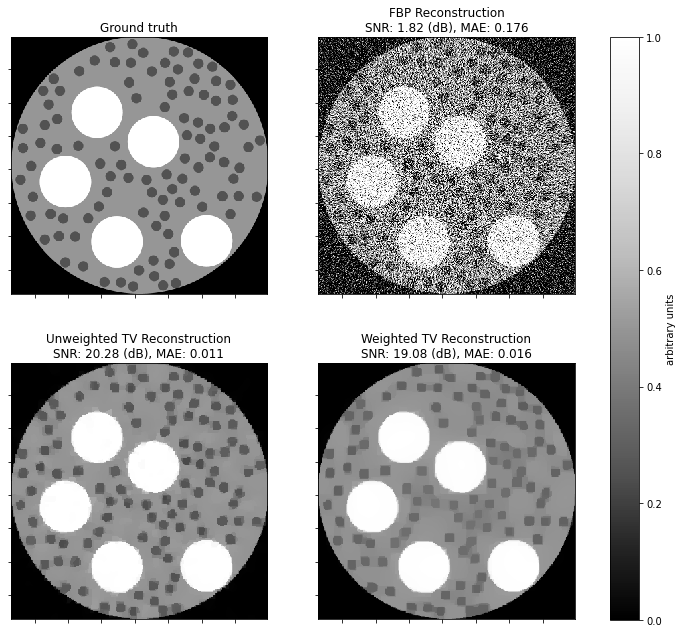

In [9]:
def plot_recon(x, title, ax):
    plot.imview(
        x,
        title=f"{title}\nSNR: {metric.snr(x_gt, x):.2f} (dB), MAE: {metric.mae(x_gt, x):.3f}",
        fig=fig,
        ax=ax,
    )


fig, ax = plot.subplots(nrows=2, ncols=2, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0])
plot_recon(x0, "FBP Reconstruction", ax=ax[0, 1])
plot_recon(x_unweighted, "Unweighted TV Reconstruction", ax=ax[1, 0])
plot_recon(x_weighted, "Weighted TV Reconstruction", ax=ax[1, 1])
for ax_ in ax.ravel():
    ax_.set_xlim(64, 448)
    ax_.set_ylim(64, 448)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="arbitrary units"
)
fig.show()